In [1]:
#Import relevant python packages
import os
import pandas as pd
import time
import numpy as np
import random
import requests
from sklearn.decomposition import PCA
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations
from collections import defaultdict

## **Goodreads Dataset Procurement and Processing**
### Scraping and collecting data

In [2]:
class GoodreadsDataset:
    
    def __init__(self, save_path: Path, num_pages: int):
        self.save_path = save_path
        self.num_pages = num_pages
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
        }
        self.home_url = "https://www.goodreads.com"
        self.base_url = "https://www.goodreads.com/list/show/1.Best_Books_Ever?page="
        self.books_data = []

    @staticmethod
    def retrieve_genres(headers: dict, book_url: str):
        # Make a request to fetch the book page for the provided book url.
        response = requests.get(url=book_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Identify genres using the HTML structure belonging to the genre category.
        genres = soup.select('a[href*="/genres/"]')
        return genres
    
    @staticmethod
    def to_csv(books_data: list, file_name: str):
        df = pd.DataFrame(books_data)
        df.to_csv(file_name, index=False)
        
    @staticmethod
    def scrape_bookpage(books_data: list, headers: dict, base_url: str, home_url: str, page: int):
        # Formulate bookpage url. 
        url = base_url + str(page)
        # Make a request to fetch the page content.
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Find all books within the page content. 
        books = soup.find_all('tr', itemtype="http://schema.org/Book")
        for book in books:
            try:
                title = book.find('a', class_="bookTitle")
                author = book.find('a', class_="authorName")
                rating = book.find('span', class_="minirating")
                book_url = home_url + title['href']
                genres = GoodreadsDataset.retrieve_genres(headers, book_url)
                # Remove leading and trailing whitespaces.
                title = title.text.strip()
                author = author.text.strip()
                rating = rating.text.strip()[:4]
                genres = [genre.text.strip() for genre in genres]
                # Construct dictionary to store fetched book data. 
                book_data = {
                    'Title': title,
                    'Author': author,
                    'Rating': rating,
                    'Genres': genres
                }
                books_data.append(book_data)
                # Implement a request delay, to ensure continous access to scraping API.
                time.sleep(2)
            except (AttributeError, ValueError):
                continue
        
        return books_data
    
    def main(self):

        filename = "goodreads_dataset.csv"
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

        filepath = os.path.join(self.save_path, filename)
        
        if not os.path.exists(filepath):
            for page in range(self.num_pages):
                print(f"Fetching books metadata from page {page}")
                books_data = self.scrape_bookpage(self.books_data, self.headers, self.base_url, self.home_url, page)
                self.books_data.extend(books_data)
                self.to_csv(self.books_data, filepath)
        else:
            print(f"Dataset CSV file already exists.")

In [3]:
filepath = os.path.join("./data", "goodreads_dataset.csv")

if not os.path.exists(filepath):
    dataset = GoodreadsDataset("./data", 10)
    dataset.main()

dataset_df = pd.read_csv(filepath)

In [4]:
dataset_df.head(10)

,Title,Author,Rating,Genres
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,"['Young Adult', 'Fiction', 'Fantasy', 'Science..."
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.50,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',..."
2,Pride and Prejudice,Jane Austen,4.29,"['Fiction', 'Historical Fiction', 'Historical'..."
3,To Kill a Mockingbird,Harper Lee,4.26,"['Fiction', 'Historical Fiction', 'School', 'L..."
4,The Book Thief,Markus Zusak,4.39,"['Historical Fiction', 'Fiction', 'Young Adult..."
5,"Twilight (The Twilight Saga, #1)",Stephenie Meyer,3.66,"['Fantasy', 'Young Adult', 'Romance', 'Fiction..."
6,Animal Farm,George Orwell,3.99,"['Fiction', 'Dystopia', 'Fantasy', 'School', '..."
7,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,4.61,"['Fantasy', 'Fiction', 'Classics', 'Adventure'..."
8,The Chronicles of Narnia (The Chronicles of Na...,C.S. Lewis,4.28,"['Fantasy', 'Classics', 'Fiction', 'Young Adul..."
9,The Fault in Our Stars,John Green,4.13,"['Young Adult', 'Fiction', 'Contemporary', 'Re..."


### Cleaning and preprocessing of data

In [5]:
class DataPreprocessor:
    def __init__(self, df):
        self.df = df.copy() 
        self.train_data = None
        self.test_data = None
    
    def clean_data(self):
        print(f"Initial shape: {self.df.shape}")
        
        # Remove rows with empty genres
        self.df = self.df.dropna(subset=['Genres'])
        print(f"Shape after removing empty genres: {self.df.shape}")
        
        # Clean and convert ratings
        self._clean_ratings()
        print(f"Shape after cleaning ratings: {self.df.shape}")
        
        # Convert genres from string to list if they're strings
        if self.df['Genres'].dtype == 'object':
            self.df['Genres'] = self.df['Genres'].apply(self._convert_genres_to_list)
        
        # Remove books with empty genre lists
        self.df = self.df[self.df['Genres'].map(len) > 0]
        print(f"Final shape: {self.df.shape}")
        
        return self.df
    
    def _clean_ratings(self):
        def convert_rating(rating):
            try:
                # Extract the first number found in the string
                if isinstance(rating, str):
                    # Remove any non-numeric characters except decimal points
                    rating = ''.join(c for c in rating if c.isdigit() or c == '.')
                return float(rating)
            except:
                return None
        
        # Convert ratings
        self.df['Rating'] = self.df['Rating'].apply(convert_rating)
        
        # Remove rows with invalid ratings
        self.df = self.df.dropna(subset=['Rating'])
        
        # Ensure ratings are within valid range (0-5)
        self.df = self.df[self.df['Rating'].between(0, 5)]
    
    def _convert_genres_to_list(self, genres_str):
        if isinstance(genres_str, list):
            return genres_str
        try:
            # Remove brackets and quotes, then split
            genres_str = genres_str.strip('[]')
            genres = [g.strip().strip("'").strip('"') for g in genres_str.split(',')]
            return [g for g in genres if g]  # Remove empty strings
        except:
            return []
    
    def create_train_test_split(self, test_size=0.2, random_state=42):
        self.train_data, self.test_data = train_test_split(
            self.df,
            test_size=test_size,
            random_state=random_state
        )
        
        print(f"Training set size: {len(self.train_data)}")
        print(f"Test set size: {len(self.test_data)}")
        
        return self.train_data, self.test_data
    
    def get_genre_statistics(self):
        all_genres = []
        for genres in self.df['Genres']:
            all_genres.extend(genres)
        
        genre_counts = pd.Series(all_genres).value_counts()
        
        print("\nGenre Statistics:")
        print(f"Total unique genres: {len(genre_counts)}")
        print("\nTop 10 most common genres:")
        print(genre_counts.head(10))
        
        return genre_counts

In [6]:
# Apply preprocessing
preprocessor = DataPreprocessor(dataset_df)
cleaned_df = preprocessor.clean_data()

# Create train-test split
train_data, test_data = preprocessor.create_train_test_split()

# Display data info
print("\nDataset info after cleaning:")
print(cleaned_df.info())

# Display some statistics
print("\nRating statistics:")
print(cleaned_df['Rating'].describe())

# Get genre statistics
genre_stats = preprocessor.get_genre_statistics()

# Create train-test split
train_data, test_data = preprocessor.create_train_test_split()

# Display sample of cleaned data
print("\nSample of cleaned data:")
print(cleaned_df.head(5))

Initial shape: (204600, 4)
Shape after removing empty genres: (204600, 4)
Shape after cleaning ratings: (200348, 4)
Final shape: (198106, 4)
Training set size: 158484
Test set size: 39622

Dataset info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 198106 entries, 0 to 204599
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Title   198106 non-null  object 
 1   Author  198106 non-null  object 
 2   Rating  198106 non-null  float64
 3   Genres  198106 non-null  object 
dtypes: float64(1), object(3)
memory usage: 7.6+ MB
None

Rating statistics:
count    198106.000000
mean          4.148599
std           0.218343
min           3.100000
25%           3.990000
50%           4.150000
75%           4.300000
max           4.810000
Name: Rating, dtype: float64

Genre Statistics:
Total unique genres: 243

Top 10 most common genres:
Fiction               191854
Classics              110560
Fantasy                89680


## **Frequent itemset algorithms**

### Apriori Algorithm

In [7]:
class Apriori:
    def __init__(self, df: pd.DataFrame, min_support: float):
        self.df = df
        self.min_support = min_support
        self.frequent_itemsets = []
        self.genres_df = self.df['Genres']
        self.df = self.one_hot_encode(self.genres_df)

    @staticmethod
    def one_hot_encode(genres_df: pd.DataFrame):
        one_hot_encoded = genres_df.apply(lambda x: pd.Series(1, index=x)).fillna(0)
        return one_hot_encoded

    @staticmethod
    def retrieve_singletons(df: pd.DataFrame):
        return df.sum(axis=0).to_dict()

    @staticmethod
    def set_of_candidates(itemsets: list[tuple], k: int):
        candidates = set()
        for i in range(len(itemsets)):
            for j in range(i + 1, len(itemsets)):
                ith_itemset = itemsets[i]
                jth_itemset = itemsets[j]
                candidate = tuple(sorted(set(ith_itemset).union(set(jth_itemset))))
                if len(candidate) == k:
                    candidates.add(candidate)
        return list(candidates)

    @staticmethod
    def compute_support(df: pd.DataFrame, itemset: tuple):
        count = df[list(itemset)].all(axis=1).sum() if all(genre in df.columns for genre in itemset) else 0
        support = count / len(df)
        return support
    
    @staticmethod
    def association_rules(df: pd.DataFrame, frequent_itemsets: dict, min_confidence: int):
        rules = []
        
        for k, itemsets in frequent_itemsets.items():
            if k < 2:
                continue
            for itemset in itemsets:
                itemset_support = Apriori.compute_support(df, itemset)
            
                for i in range(1, len(itemset)):
                    antecedents = combinations(itemset, i)
                    for antecedent in antecedents:
                        antecedent_support = Apriori.compute_support(df, antecedent)
                        consequent = tuple(set(itemset) - set(antecedent))
                        consequent_support = Apriori.compute_support(df, consequent)

                        confidence = itemset_support / antecedent_support
                        lift = confidence / consequent_support

                        if confidence >= min_confidence:
                            rules.append({
                                'antecedents': antecedent,
                                'consequents': consequent,
                                'antecedent support': antecedent_support,
                                'consequent support': consequent_support,
                                'support': itemset_support,
                                'confidence': confidence,
                                'lift': lift
                            })

        return rules

    def apriori(self, min_confidence: int):

        freq_itemsets = {}
        frequent_1_itemsets = []
    
        # Generate 1-itemsets
        singletons = self.retrieve_singletons(self.df)
        k = 1

        for genre, count in singletons.items():
            support = count / len(self.df)
            if support >= self.min_support:
                self.frequent_itemsets.append({'support': support, 'itemsets': (genre,)})
                frequent_1_itemsets.append((genre,))
        
        freq_itemsets[k] = frequent_1_itemsets
            
        # Generate k-itemsets
        k = 2
        while True:
            candidates = self.set_of_candidates(freq_itemsets[k - 1], k)
            frequent_k_itemsets = []
            frequent_itemsets = []
            for candidate in candidates:
                support = self.compute_support(self.df, candidate)
                if support >= self.min_support:
                    frequent_itemsets.append({'support': support, 'itemsets': (candidate)})
                    frequent_k_itemsets.append(candidate)
            if not frequent_itemsets:
                break
            else:
                freq_itemsets[k] = frequent_k_itemsets
                k += 1
                self.frequent_itemsets.extend(frequent_itemsets)

        association_rules = self.association_rules(self.df, freq_itemsets, min_confidence)

        return pd.DataFrame(self.frequent_itemsets), pd.DataFrame(association_rules)

In [8]:
# Initialize the Apriori class.
apriori_custom = Apriori(train_data, min_support=0.05)

# Perform the apriori algorithm to generate frequent itemsets and assocation rules. 
frequent_itemsets_custom, rules_custom = apriori_custom.apriori(min_confidence=0.7)

# Perform the apriori algorithm using another python package.
frequent_itemsets = apriori(apriori_custom.df, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric = 'confidence', min_threshold=0.7)


c:\Users\Frederik\miniconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [9]:
print("\nSample of frequent itemsets")
print(frequent_itemsets_custom.head(5))
print("\nSample of frequent itemsets obtained using mlxtend")
print(frequent_itemsets.head(5))
print("\nSample of association rules")
print(rules_custom.head(5))



Sample of frequent itemsets
    support       itemsets
0  0.558328    (Classics,)
1  0.968237     (Fiction,)
2  0.452847     (Fantasy,)
3  0.179179   (Childrens,)
4  0.053614  (Philosophy,)

Sample of frequent itemsets obtained using mlxtend
    support      itemsets
0  0.558328    (Classics)
1  0.968237     (Fiction)
2  0.452847     (Fantasy)
3  0.179179   (Childrens)
4  0.053614  (Philosophy)

Sample of association rules
       antecedents   consequents  antecedent support  consequent support  \
0  (Middle Grade,)    (Fantasy,)            0.104465            0.452847   
1         (Crime,)    (Fiction,)            0.055652            0.968237   
2        (Gothic,)    (Fiction,)            0.066190            0.968237   
3  (Middle Grade,)  (Childrens,)            0.104465            0.179179   
4   (Young Adult,)    (Fiction,)            0.376593            0.968237   

    support  confidence      lift  
0  0.083359    0.797958  1.762093  
1  0.054125    0.972562  1.004468  
2  0.06

### PCY Algorithm

In [10]:
class PCY:
    def __init__(self, df, min_support, hash_size=10):
        self.df = df
        self.min_support = min_support
        self.hash_size = hash_size
        self.freq_itemsets = []
        self.genres_df = self.df['Genres']
        self.df = self.one_hot_encode(self.genres_df)  # One-hot encode genres for transaction format
        self.transactions = self.df_to_transactions() 
        self.num_transactions = len(self.transactions)

    @staticmethod
    def one_hot_encode(genres_df):
        one_hot_encoded = genres_df.apply(lambda x: pd.Series(1, index=x)).fillna(0)
        return one_hot_encoded

    def df_to_transactions(self):
        # Convert one-hot encoded df to list of transactions
        transactions = []
        for _, row in self.df.iterrows():
            transaction = row.index[row == 1].tolist() 
            transactions.append(transaction)
        return transactions

    def filter_freq_items(self, item_count):
        # Filters based on minimum support threshold
        freq_items = set()
        for item, count in item_count.items():
            if count / self.num_transactions >= self.min_support:
                freq_items.add(item)

        return freq_items
    
    def filter_freq_buckets_to_bitmap(self, hash_table):
        # Converts frequent buckets into a bitmap
        bitmap = np.zeros(self.hash_size, dtype=bool)
        for i, count in enumerate(hash_table):
            if count / self.num_transactions >= self.min_support:
                bitmap[i] = True
        return bitmap
    
    def pass_one(self):
        # Count single items and hash item pairs into buckets
        item_count = defaultdict(int)
        hash_table = np.zeros(self.hash_size, dtype=int)

        for transaction in self.transactions:
            for item in transaction:
                item_count[item] += 1
            for item_pair in combinations(transaction, 2):
                hash_value = hash(frozenset(item_pair)) % self.hash_size  
                hash_table[hash_value] += 1

        return item_count, hash_table

    def pass_two(self, freq_items, bitmap):
        # Count pairs that are both frequent items and hashed to frequent buckets using the bitmap
        pair_count = defaultdict(int)

        for transaction in self.transactions:
            for item_pair in combinations(transaction, 2):
                if item_pair[0] in freq_items and item_pair[1] in freq_items:
                    hash_value = hash(frozenset(item_pair)) % self.hash_size
                    if bitmap[hash_value]:  
                        pair_count[item_pair] += 1

        freq_pairs = {}
        for pair, count in pair_count.items():
            support = count / self.num_transactions
            if support >= self.min_support:
                freq_pairs[pair] = count

        return freq_pairs

    def run_pcy(self):
        item_count, hash_table = self.pass_one()

        freq_items = self.filter_freq_items(item_count)

        # Only keep items that meet the minimum support threshold
        filtered_item_count = {item: count for item, count in item_count.items() if item in freq_items}

        bitmap = self.filter_freq_buckets_to_bitmap(hash_table)

        freq_pairs = self.pass_two(freq_items, bitmap)

        for item, count in filtered_item_count.items():
            support = count / self.num_transactions
            if support >= self.min_support:  
                itemset = {'support': support, 'itemset': (item,)}
                self.freq_itemsets.append(itemset)

        for pair, count in freq_pairs.items():
            support = count / self.num_transactions
            itemset = {'support': support, 'itemset': set(pair)}
            self.freq_itemsets.append(itemset)

        return pd.DataFrame(self.freq_itemsets)


In [11]:
pcy = PCY(train_data, min_support=0.05)
freq_itemsets_pcy = pcy.run_pcy()

print(freq_itemsets_pcy.head(10))



    support                itemset
0  0.558328            (Classics,)
1  0.968237             (Fiction,)
2  0.452847             (Fantasy,)
3  0.179179           (Childrens,)
4  0.053614          (Philosophy,)
5  0.376593         (Young Adult,)
6  0.147750     (Science Fiction,)
7  0.329566  (Historical Fiction,)
8  0.371886          (Literature,)
9  0.291342              (Novels,)


In [12]:
# only package of a black-box PCY I could find to compare with but I can't currently get it to run.
# however, it does give the same result as A-Priori

# import pyfim 

# result = pyfim.pcy(df, min_support=2)
# print(result)

## **Clustering**

### K-Means Clustering

In [13]:
class KMeansClustering:
    def __init__(self, df, n_clusters=3, random_state=42):
        self.df = df.copy()
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.genre_to_index = {}
        self.all_genres = []
        self.feature_matrix = None
        self.custom_labels = None
        self.sklearn_labels = None
        self.custom_centroids = None
        self.sklearn_centroids = None
        self.X_pca = None

    def prepare_data(self):
        # Get all unique genres
        all_genres = set()
        for genres in self.df['Genres']:
            all_genres.update(genres)
        self.all_genres = sorted(all_genres)
        
        # Create a mapping from genre to index
        self.genre_to_index = {genre: idx for idx, genre in enumerate(self.all_genres)}
        
        # Convert genres to one-hot encoded vectors
        self.df['Genre_Vector'] = self.df['Genres'].apply(self._genres_to_onehot)
        
        # Scale the Rating feature
        scaler = StandardScaler()
        self.df['Scaled_Rating'] = scaler.fit_transform(self.df[['Rating']])
        
        # Combine Genre_Vector and Scaled_Rating into a single feature vector
        feature_vectors = np.stack(self.df['Genre_Vector'].values)
        ratings = self.df['Scaled_Rating'].values.reshape(-1, 1)
        self.feature_matrix = np.hstack((feature_vectors, ratings))

    def _genres_to_onehot(self, genres_list):
        vector = np.zeros(len(self.all_genres))
        for genre in genres_list:
            idx = self.genre_to_index.get(genre)
            if idx is not None:
                vector[idx] = 1
        return vector

    def fit_custom_kmeans(self):
        # Implement K-means clustering
        np.random.seed(self.random_state)
        initial_centroid_indices = np.random.choice(len(self.feature_matrix), self.n_clusters, replace=False)
        self.custom_centroids = self.feature_matrix[initial_centroid_indices]
        
        for iteration in range(300):  # max_iter=300
            # Assign clusters
            distances = self._compute_distances(self.feature_matrix, self.custom_centroids)
            labels = np.argmin(distances, axis=1)
            # Update centroids
            new_centroids = np.zeros_like(self.custom_centroids)
            for k in range(self.n_clusters):
                cluster_points = self.feature_matrix[labels == k]
                if len(cluster_points) > 0:
                    new_centroids[k] = cluster_points.mean(axis=0)
                else:
                    # Reinitialize centroid if cluster is empty
                    new_centroids[k] = self.feature_matrix[np.random.choice(len(self.feature_matrix))]
            # Check for convergence
            if np.allclose(self.custom_centroids, new_centroids, atol=1e-4):
                break
            self.custom_centroids = new_centroids
        self.custom_labels = labels

    def fit_sklearn_kmeans(self):
        kmeans = KMeans(
            n_clusters=self.n_clusters,
            init=self.custom_centroids,
            n_init=1,
            max_iter=300,
            tol=1e-4,
            algorithm='lloyd', 
            random_state=self.random_state
        )
        kmeans.fit(self.feature_matrix)
        self.sklearn_labels = kmeans.labels_
        self.sklearn_centroids = kmeans.cluster_centers_

    def _compute_distances(self, X, centroids):
        return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    def calculate_davies_bouldin_index(self, labels, centroids):
        n_clusters = len(centroids)
        cluster_k = [self.feature_matrix[labels == k] for k in range(n_clusters)]
        s = [np.mean(np.linalg.norm(cluster - centroids[i], axis=1)) for i, cluster in enumerate(cluster_k)]
        db_index = 0
        for i in range(n_clusters):
            max_ratio = max(
                [(s[i] + s[j]) / np.linalg.norm(centroids[i] - centroids[j]) 
                 for j in range(n_clusters) if j != i]
            )
            db_index += max_ratio
        db_index /= n_clusters
        return db_index

    def visualize_clusters(self, labels, title):
        # Reduce dimensions to 2D using PCA
        pca = PCA(n_components=2)
        self.X_pca = pca.fit_transform(self.feature_matrix)
        
        # Plotting
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(self.X_pca[:, 0], self.X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Clusters")
        plt.title(title)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()

    def run_all(self):
        # Prepare data
        self.prepare_data()
        print("Data preparation complete.")
        
        # Fit custom KMeans
        self.fit_custom_kmeans()
        print("Custom KMeans clustering complete.")
        
        # Fit sklearn KMeans
        self.fit_sklearn_kmeans()
        print("sklearn KMeans clustering complete.")
        
        # Calculate Davies-Bouldin Index for custom KMeans
        db_index_custom = self.calculate_davies_bouldin_index(self.custom_labels, self.custom_centroids)
        print("Davies-Bouldin Index (Custom KMeans):", db_index_custom)
        
        # Calculate Davies-Bouldin Index for sklearn KMeans
        db_index_sklearn = self.calculate_davies_bouldin_index(self.sklearn_labels, self.sklearn_centroids)
        print("Davies-Bouldin Index (sklearn KMeans):", db_index_sklearn)
        
        # Visualize clusters for custom KMeans
        self.visualize_clusters(self.custom_labels, "Clusters from Custom KMeans")
        
        # Visualize clusters for sklearn KMeans
        self.visualize_clusters(self.sklearn_labels, "Clusters from sklearn KMeans")


Data preparation complete.
Custom KMeans clustering complete.
sklearn KMeans clustering complete.
Davies-Bouldin Index (Custom KMeans): 2.4492122127008846
Davies-Bouldin Index (sklearn KMeans): 2.4492122127008207


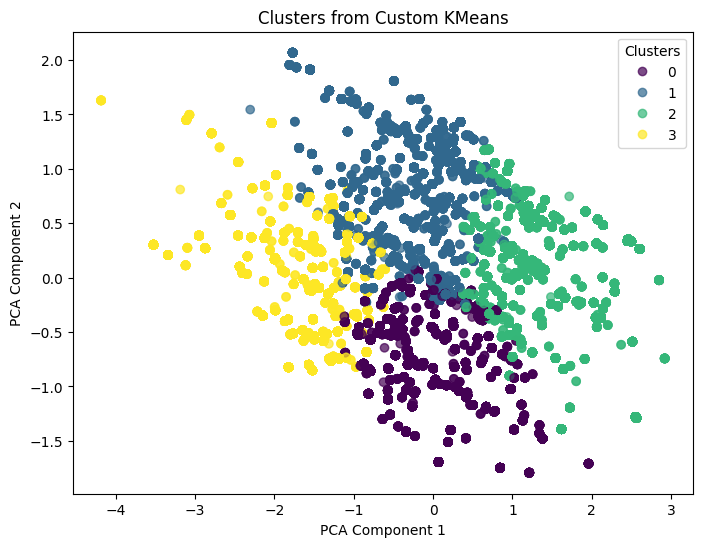

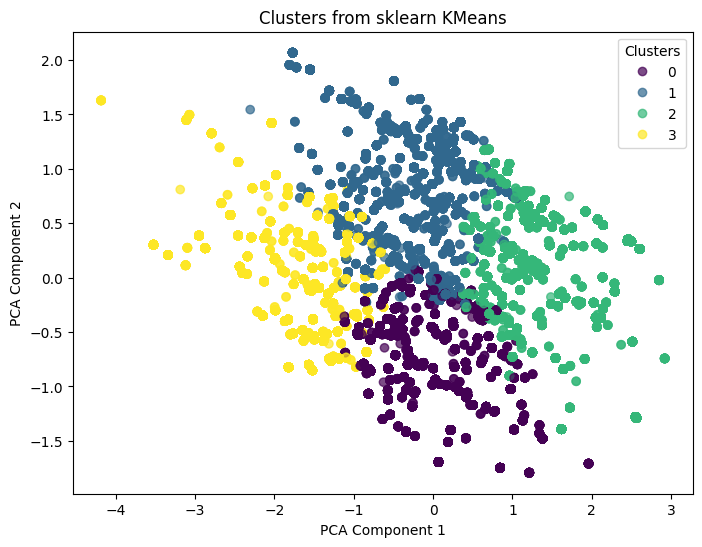

In [14]:
# Initialize the clustering class
clustering = KMeansClustering(train_data, n_clusters=4, random_state=42)

# Run all steps
clustering.run_all()


### DBSCAN Clustering

## **Recommendation System**

### Using frequent itemsets (Apriori/PCY)

### Using clusters (K-means/DBSCAN)

### Combine both approaches

## **Evaluation and Metrics**